In [7]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy.interpolate import interp1d
import time as t

## get individual session data from lomg

In [8]:
LONG_DF = pd.read_csv('long_data_raw.csv')
def getIndividualTrial(pid,trial):
    return LONG_DF.loc[(LONG_DF.trial==trial) & (LONG_DF.pid==pid)]

def getParticipantData(pid):
    return LONG_DF.loc[LONG_DF.pid==pid]

In [9]:
# stimming, can ignore

# print(len(LONG_DF.loc[(LONG_DF.pid == 1), "valence"]))
# print(len(LONG_DF.loc[(LONG_DF.pid == 1)]))




In [10]:
def minMaxNormalize(x):
    return 2 * ((x - min(x)) / (max(x)-min(x))) - 1

for pid in set(LONG_DF.pid):
    print(".................\npid: ",pid)
    print("before: ", LONG_DF.loc[(LONG_DF.pid == pid), "valence"])

    LONG_DF.loc[(LONG_DF.pid == pid), "arousal"] = minMaxNormalize(LONG_DF.loc[(
        LONG_DF.pid == pid), "arousal"])
    LONG_DF.loc[(LONG_DF.pid == pid), "valence"] = minMaxNormalize(LONG_DF.loc[(
        LONG_DF.pid == pid), "valence"])
        
    print("after: ", LONG_DF.loc[(LONG_DF.pid == pid), "arousal"])



.................
pid:  1
before:  5319     0.268571
5320     0.268571
5321     0.268571
5322     0.268571
5323     0.268571
           ...   
85718   -1.040000
85719   -1.040000
85720   -1.034286
85721   -1.034286
85722   -1.034286
Name: valence, Length: 5814, dtype: float64
after:  5319    -0.448276
5320    -0.448276
5321    -0.448276
5322    -0.448276
5323    -0.448276
           ...   
85718    0.970443
85719    0.970443
85720    0.970443
85721    0.970443
85722    0.970443
Name: arousal, Length: 5814, dtype: float64
.................
pid:  2
before:  2020    -0.760000
2021    -0.760000
2022    -0.760000
2023    -0.765714
2024    -0.771429
           ...   
82967   -1.080000
82968   -1.091429
82969   -1.097143
82970   -1.097143
82971   -1.097143
Name: valence, Length: 9994, dtype: float64
after:  2020     0.409471
2021     0.409471
2022     0.409471
2023     0.398329
2024     0.381616
           ...   
82967    0.894150
82968    0.910864
82969    0.927577
82970    0.933148
82971   

In [11]:
# Globals.
SAMPLE_RATE = 2 # prev 250
DATA_PATH = "../data"

# Helpers.


# def clean_data(df):

#     '''
#     returns df, pid
#     '''
#     # Extract participant ID no.
#     pid = df['PID'][0]

#     # Remove extrananeous rows/columns.
#     df = df.drop([0])
#     df = df.drop(columns=['tags', 'PID'])
#     return df, pid


def resample_cursor_data(pid, trial, sample_rate=SAMPLE_RATE):
    # time_ms = [event['timeMs'] for event in time_series]
    # valence = [event['valence'] for event in time_series]
    # arousal = [event['arousal'] for event in time_series]
    
    time_ms = np.array(getIndividualTrial(pid, trial).timeMs)
    valence = np.array(getIndividualTrial(pid, trial).valence)
    arousal = np.array(getIndividualTrial(pid, trial).arousal)
    
    time_ms = np.concatenate([[1000], time_ms])
    valence = np.concatenate([[1000], valence])
    arousal = np.concatenate([[1000], arousal])

    # time_ms.insert(0, 0.0)
    # valence.insert(0, 0.0)
    # arousal.insert(0, 0.0)

    valence_func = interp1d(time_ms, valence)
    arousal_func = interp1d(time_ms, arousal)

    period = 1/SAMPLE_RATE
    resample_time = np.arange(1000, time_ms[-1], period)

    valence = valence_func(resample_time)
    arousal = arousal_func(resample_time)

    time_s = resample_time / 1000

    return time_s, valence, arousal

    

def my_plot(time, valence, arousal, show=True):
    plt.plot(time, valence)
    plt.plot(time, arousal)
    plt.xlabel('Time (s)')
    plt.ylabel('Normalized value')
    plt.legend({'Valence', 'Arousal'})
    if show:
        plt.show()


# Analysis

Sample analysis below. Specify filename and trial number to visualize valence and arousal values over time.

## build new linear interpolated csv

In [12]:

startTime = t.time()

startPid = 0
startTrial = 0

dt = np.dtype([('pid', np.int8),
               ('arousal', np.float64),
               ('valence', np.float64),
               ('timeS', np.float64),
               ('slideshow', 'U1'),
               ('viz', 'U1'),
               ('session', 'U1'),
               ('trial', np.int8), ])


for pid in set(LONG_DF.pid):
    
    if(pid >= startPid):
        mommyArr = np.empty([0], dtype=dt)
        print(pd.DataFrame(mommyArr))
        # allocate new array for the dataframes
        # dfArray = np.empty(len(set(LONG_DF.pid)) *
        #                    len(set(LONG_DF.trial)), dtype=pd.DataFrame)

        # dfArray = np.empty(len(set(LONG_DF.trial)), dtype=pd.DataFrame) # dataframe array
        for trial in set(LONG_DF.trial):
            if(trial >= startTrial):
                slideshow = LONG_DF.loc[(LONG_DF.pid == pid) & (
                    LONG_DF.trial == trial)].slideshow.iloc[0]
                viz = LONG_DF.loc[(LONG_DF.pid == pid) & (
                    LONG_DF.trial == trial)].viz.iloc[0]
                session = LONG_DF.loc[(LONG_DF.pid == pid) & (
                    LONG_DF.trial == trial)].session.iloc[0]
                print(f'accessing pid: {pid}; trial: {trial}; slideshow: {slideshow}; viz {viz}; session {session}\n ({t.time() - startTime}s)')
                time, valence, arousal = resample_cursor_data(pid, trial)

                arr = np.empty([len(time)], dtype=dt)
                for i in range(0, len(time)):
                    arr[i]['pid'] = pid
                    arr[i]['arousal'] = arousal[i]
                    arr[i]['valence'] = valence[i]
                    arr[i]['timeS'] = time[i]
                    arr[i]['slideshow'] = slideshow
                    arr[i]['viz'] = viz
                    arr[i]['session'] = session
                    arr[i]['trial'] = trial
                
                # filePath = f'processed_data/pid{pid}trial{trial}interp.csv'
                
                # print(f'writing to: {filePath}')
                # pd.DataFrame(arr).to_csv(filePath, index=False)
                
                print(f'concatenating pid: {pid},trial: {trial}...')
                mommyArr = np.append(mommyArr,arr)
                arr = None 
                time = None 
                valence = None 
                arousal = None 
        
        print(f'writing to: processed_data/{pid}_interp_data.csv')
        pd.DataFrame(mommyArr).to_csv(f'processed_data/pid{pid}-interpData.csv',index=False)
        mommyArr = None

print('complete!')



Empty DataFrame
Columns: [pid, arousal, valence, timeS, slideshow, viz, session, trial]
Index: []
accessing pid: 1; trial: 1; slideshow: A; viz B; session 3
 (0.020518064498901367s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 1,trial: 1...
accessing pid: 1; trial: 2; slideshow: A; viz 0; session 3
 (0.5688397884368896s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 1,trial: 2...
accessing pid: 1; trial: 3; slideshow: B; viz A; session 3
 (1.0720305442810059s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 1,trial: 3...
accessing pid: 1; trial: 4; slideshow: A; viz A; session 3
 (1.7413568496704102s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 1,trial: 4...
accessing pid: 1; trial: 5; slideshow: A; viz 0; session 3
 (2.247342824935913s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 1,trial: 5...
accessing pid: 1; trial: 6; slideshow: B; viz B; session 3
 (2.765178918838501s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 1,trial: 6...
accessing pid: 1; trial: 7; slideshow: A; viz A; session 3
 (3.52268123626709s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 1,trial: 7...
accessing pid: 1; trial: 8; slideshow: B; viz A; session 3
 (4.040525913238525s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 1,trial: 8...
accessing pid: 1; trial: 9; slideshow: A; viz B; session 3
 (4.735217809677124s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 1,trial: 9...
accessing pid: 1; trial: 10; slideshow: B; viz 0; session 3
 (5.259720325469971s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 1,trial: 10...
accessing pid: 1; trial: 11; slideshow: B; viz B; session 3
 (5.970393180847168s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 1,trial: 11...
accessing pid: 1; trial: 12; slideshow: B; viz 0; session 3
 (6.6737589836120605s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 1,trial: 12...
writing to: processed_data/1_interp_data.csv
Empty DataFrame
Columns: [pid, arousal, valence, timeS, slideshow, viz, session, trial]
Index: []
accessing pid: 2; trial: 1; slideshow: B; viz 0; session 4
 (13.241297960281372s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 2,trial: 1...
accessing pid: 2; trial: 2; slideshow: A; viz A; session 4
 (13.626784801483154s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 2,trial: 2...
accessing pid: 2; trial: 3; slideshow: B; viz A; session 4
 (14.285813570022583s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 2,trial: 3...
accessing pid: 2; trial: 4; slideshow: A; viz 0; session 4
 (14.677078247070312s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 2,trial: 4...
accessing pid: 2; trial: 5; slideshow: B; viz B; session 4
 (15.364566087722778s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 2,trial: 5...
accessing pid: 2; trial: 6; slideshow: B; viz A; session 4
 (15.742558479309082s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 2,trial: 6...
accessing pid: 2; trial: 7; slideshow: B; viz 0; session 4
 (16.13110876083374s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 2,trial: 7...
accessing pid: 2; trial: 8; slideshow: A; viz B; session 4
 (16.51491403579712s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 2,trial: 8...
accessing pid: 2; trial: 9; slideshow: A; viz A; session 4
 (17.23504376411438s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 2,trial: 9...
accessing pid: 2; trial: 10; slideshow: B; viz B; session 4
 (17.904259204864502s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 2,trial: 10...
accessing pid: 2; trial: 11; slideshow: A; viz B; session 4
 (18.290488958358765s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 2,trial: 11...
accessing pid: 2; trial: 12; slideshow: A; viz 0; session 4
 (19.02580690383911s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 2,trial: 12...
writing to: processed_data/2_interp_data.csv
Empty DataFrame
Columns: [pid, arousal, valence, timeS, slideshow, viz, session, trial]
Index: []
accessing pid: 3; trial: 1; slideshow: A; viz B; session 3
 (24.63054895401001s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 3,trial: 1...
accessing pid: 3; trial: 2; slideshow: B; viz 0; session 3
 (25.123546361923218s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 3,trial: 2...
accessing pid: 3; trial: 3; slideshow: A; viz 0; session 3
 (25.798254251480103s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 3,trial: 3...
accessing pid: 3; trial: 4; slideshow: B; viz B; session 3
 (26.30736517906189s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 3,trial: 4...
accessing pid: 3; trial: 5; slideshow: A; viz A; session 3
 (27.091521501541138s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 3,trial: 5...
accessing pid: 3; trial: 6; slideshow: B; viz A; session 3
 (27.7662410736084s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 3,trial: 6...
accessing pid: 3; trial: 7; slideshow: A; viz A; session 3
 (28.531124591827393s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 3,trial: 7...
accessing pid: 3; trial: 8; slideshow: B; viz 0; session 3
 (29.04716658592224s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 3,trial: 8...
accessing pid: 3; trial: 9; slideshow: B; viz A; session 3
 (29.702820539474487s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 3,trial: 9...
accessing pid: 3; trial: 10; slideshow: A; viz B; session 3
 (30.383525609970093s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 3,trial: 10...
accessing pid: 3; trial: 11; slideshow: A; viz 0; session 3
 (30.968247413635254s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 3,trial: 11...
accessing pid: 3; trial: 12; slideshow: B; viz B; session 3
 (31.832234621047974s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 3,trial: 12...
writing to: processed_data/3_interp_data.csv
Empty DataFrame
Columns: [pid, arousal, valence, timeS, slideshow, viz, session, trial]
Index: []
accessing pid: 6; trial: 1; slideshow: A; viz 0; session 4
 (38.652355909347534s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 6,trial: 1...
accessing pid: 6; trial: 2; slideshow: B; viz B; session 4
 (39.41665029525757s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 6,trial: 2...
accessing pid: 6; trial: 3; slideshow: B; viz 0; session 4
 (39.7842800617218s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 6,trial: 3...
accessing pid: 6; trial: 4; slideshow: A; viz B; session 4
 (40.17773985862732s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 6,trial: 4...
accessing pid: 6; trial: 5; slideshow: A; viz 0; session 4
 (40.84125828742981s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 6,trial: 5...
accessing pid: 6; trial: 6; slideshow: B; viz A; session 4
 (41.57455897331238s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 6,trial: 6...
accessing pid: 6; trial: 7; slideshow: A; viz B; session 4
 (41.94362926483154s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 6,trial: 7...
accessing pid: 6; trial: 8; slideshow: B; viz B; session 4
 (42.60320448875427s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 6,trial: 8...
accessing pid: 6; trial: 9; slideshow: B; viz A; session 4
 (42.97472858428955s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 6,trial: 9...
accessing pid: 6; trial: 10; slideshow: A; viz A; session 4
 (43.338359117507935s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 6,trial: 10...
accessing pid: 6; trial: 11; slideshow: B; viz 0; session 4
 (44.019373655319214s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 6,trial: 11...
accessing pid: 6; trial: 12; slideshow: A; viz A; session 4
 (44.48380899429321s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 6,trial: 12...
writing to: processed_data/6_interp_data.csv
Empty DataFrame
Columns: [pid, arousal, valence, timeS, slideshow, viz, session, trial]
Index: []
accessing pid: 7; trial: 1; slideshow: B; viz B; session 3
 (50.11637210845947s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 7,trial: 1...
accessing pid: 7; trial: 2; slideshow: A; viz B; session 3
 (50.76189827919006s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 7,trial: 2...
accessing pid: 7; trial: 3; slideshow: A; viz A; session 3
 (51.26264691352844s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 7,trial: 3...
accessing pid: 7; trial: 4; slideshow: A; viz A; session 3
 (51.75500965118408s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 7,trial: 4...
accessing pid: 7; trial: 5; slideshow: B; viz 0; session 3
 (52.26379680633545s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 7,trial: 5...
accessing pid: 7; trial: 6; slideshow: B; viz 0; session 3
 (52.92447543144226s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 7,trial: 6...
accessing pid: 7; trial: 7; slideshow: A; viz 0; session 3
 (53.572771310806274s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 7,trial: 7...
accessing pid: 7; trial: 8; slideshow: B; viz B; session 3
 (54.1407675743103s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 7,trial: 8...
accessing pid: 7; trial: 9; slideshow: A; viz B; session 3
 (54.829566955566406s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 7,trial: 9...
accessing pid: 7; trial: 10; slideshow: A; viz 0; session 3
 (55.39019560813904s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 7,trial: 10...
accessing pid: 7; trial: 11; slideshow: B; viz A; session 3
 (55.92929291725159s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 7,trial: 11...
accessing pid: 7; trial: 12; slideshow: B; viz A; session 3
 (56.72578454017639s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 7,trial: 12...
writing to: processed_data/7_interp_data.csv
Empty DataFrame
Columns: [pid, arousal, valence, timeS, slideshow, viz, session, trial]
Index: []
accessing pid: 8; trial: 1; slideshow: B; viz 0; session 4
 (63.978010177612305s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 8,trial: 1...
accessing pid: 8; trial: 2; slideshow: A; viz 0; session 4
 (64.42346382141113s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 8,trial: 2...
accessing pid: 8; trial: 3; slideshow: A; viz B; session 4
 (65.20963191986084s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 8,trial: 3...
accessing pid: 8; trial: 4; slideshow: B; viz 0; session 4
 (66.03745293617249s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 8,trial: 4...
accessing pid: 8; trial: 5; slideshow: B; viz A; session 4
 (66.48268580436707s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 8,trial: 5...
accessing pid: 8; trial: 6; slideshow: B; viz B; session 4
 (66.85206627845764s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 8,trial: 6...
accessing pid: 8; trial: 7; slideshow: A; viz 0; session 4
 (67.24344205856323s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 8,trial: 7...
accessing pid: 8; trial: 8; slideshow: B; viz A; session 4
 (67.98698568344116s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 8,trial: 8...
accessing pid: 8; trial: 9; slideshow: A; viz B; session 4
 (68.38184523582458s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 8,trial: 9...
accessing pid: 8; trial: 10; slideshow: A; viz A; session 4
 (69.12164497375488s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 8,trial: 10...
accessing pid: 8; trial: 11; slideshow: B; viz B; session 4
 (69.79037261009216s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 8,trial: 11...
accessing pid: 8; trial: 12; slideshow: A; viz A; session 4
 (70.15271472930908s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 8,trial: 12...
writing to: processed_data/8_interp_data.csv
Empty DataFrame
Columns: [pid, arousal, valence, timeS, slideshow, viz, session, trial]
Index: []
accessing pid: 9; trial: 1; slideshow: B; viz A; session 3
 (75.50427174568176s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 9,trial: 1...
accessing pid: 9; trial: 2; slideshow: A; viz 0; session 3
 (76.16717147827148s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 9,trial: 2...
accessing pid: 9; trial: 3; slideshow: B; viz 0; session 3
 (76.69621419906616s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 9,trial: 3...
accessing pid: 9; trial: 4; slideshow: A; viz B; session 3
 (77.3443648815155s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 9,trial: 4...
accessing pid: 9; trial: 5; slideshow: B; viz 0; session 3
 (77.83025193214417s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 9,trial: 5...
accessing pid: 9; trial: 6; slideshow: A; viz 0; session 3
 (78.51024746894836s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 9,trial: 6...
accessing pid: 9; trial: 7; slideshow: A; viz A; session 3
 (78.9850058555603s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 9,trial: 7...
accessing pid: 9; trial: 8; slideshow: B; viz B; session 3
 (79.45860290527344s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 9,trial: 8...
accessing pid: 9; trial: 9; slideshow: A; viz B; session 3
 (80.1283209323883s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 9,trial: 9...
accessing pid: 9; trial: 10; slideshow: B; viz A; session 3
 (80.62024641036987s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 9,trial: 10...
accessing pid: 9; trial: 11; slideshow: B; viz B; session 3
 (81.31405830383301s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 9,trial: 11...
accessing pid: 9; trial: 12; slideshow: A; viz A; session 3
 (81.98316836357117s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 9,trial: 12...
writing to: processed_data/9_interp_data.csv
Empty DataFrame
Columns: [pid, arousal, valence, timeS, slideshow, viz, session, trial]
Index: []
accessing pid: 11; trial: 1; slideshow: B; viz B; session 3
 (87.68319749832153s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 11,trial: 1...
accessing pid: 11; trial: 2; slideshow: B; viz 0; session 3
 (88.3348560333252s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 11,trial: 2...
accessing pid: 11; trial: 3; slideshow: A; viz A; session 3
 (89.01206946372986s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 11,trial: 3...
accessing pid: 11; trial: 4; slideshow: A; viz B; session 3
 (89.4872043132782s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 11,trial: 4...
accessing pid: 11; trial: 5; slideshow: B; viz 0; session 3
 (89.97338056564331s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 11,trial: 5...
accessing pid: 11; trial: 6; slideshow: B; viz B; session 3
 (90.63177871704102s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 11,trial: 6...
accessing pid: 11; trial: 7; slideshow: A; viz 0; session 3
 (91.29737758636475s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 11,trial: 7...
accessing pid: 11; trial: 8; slideshow: A; viz A; session 3
 (91.7836799621582s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 11,trial: 8...
accessing pid: 11; trial: 9; slideshow: B; viz A; session 3
 (92.28322625160217s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 11,trial: 9...
accessing pid: 11; trial: 10; slideshow: B; viz A; session 3
 (92.91076278686523s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 11,trial: 10...
accessing pid: 11; trial: 11; slideshow: A; viz B; session 3
 (93.58351826667786s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 11,trial: 11...
accessing pid: 11; trial: 12; slideshow: A; viz 0; session 3
 (94.08453798294067s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 11,trial: 12...
writing to: processed_data/11_interp_data.csv
Empty DataFrame
Columns: [pid, arousal, valence, timeS, slideshow, viz, session, trial]
Index: []
accessing pid: 12; trial: 1; slideshow: A; viz B; session 4
 (99.78283047676086s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 12,trial: 1...
accessing pid: 12; trial: 2; slideshow: B; viz B; session 4
 (100.45989060401917s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 12,trial: 2...
accessing pid: 12; trial: 3; slideshow: B; viz 0; session 4
 (100.82537007331848s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 12,trial: 3...
accessing pid: 12; trial: 4; slideshow: B; viz A; session 4
 (101.24678421020508s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 12,trial: 4...
accessing pid: 12; trial: 5; slideshow: A; viz A; session 4
 (101.61274862289429s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 12,trial: 5...
accessing pid: 12; trial: 6; slideshow: B; viz 0; session 4
 (102.29020237922668s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 12,trial: 6...
accessing pid: 12; trial: 7; slideshow: A; viz 0; session 4
 (102.65857100486755s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 12,trial: 7...
accessing pid: 12; trial: 8; slideshow: A; viz 0; session 4
 (103.35493278503418s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 12,trial: 8...
accessing pid: 12; trial: 9; slideshow: B; viz B; session 4
 (104.02164459228516s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 12,trial: 9...
accessing pid: 12; trial: 10; slideshow: A; viz A; session 4
 (104.39559841156006s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 12,trial: 10...
accessing pid: 12; trial: 11; slideshow: B; viz A; session 4
 (105.05596566200256s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 12,trial: 11...
accessing pid: 12; trial: 12; slideshow: A; viz B; session 4
 (105.43514585494995s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 12,trial: 12...
writing to: processed_data/12_interp_data.csv
Empty DataFrame
Columns: [pid, arousal, valence, timeS, slideshow, viz, session, trial]
Index: []
accessing pid: 13; trial: 1; slideshow: B; viz B; session 3
 (110.87528395652771s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 13,trial: 1...
accessing pid: 13; trial: 2; slideshow: B; viz A; session 3
 (111.54475951194763s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 13,trial: 2...
accessing pid: 13; trial: 3; slideshow: B; viz B; session 3
 (112.20332789421082s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 13,trial: 3...
accessing pid: 13; trial: 4; slideshow: A; viz 0; session 3
 (112.8385808467865s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 13,trial: 4...
accessing pid: 13; trial: 5; slideshow: A; viz B; session 3
 (113.34944725036621s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 13,trial: 5...
accessing pid: 13; trial: 6; slideshow: A; viz B; session 3
 (113.86298894882202s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 13,trial: 6...
accessing pid: 13; trial: 7; slideshow: A; viz 0; session 3
 (114.36949253082275s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 13,trial: 7...
accessing pid: 13; trial: 8; slideshow: B; viz 0; session 3
 (114.86135149002075s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 13,trial: 8...
accessing pid: 13; trial: 9; slideshow: A; viz A; session 3
 (115.52565503120422s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 13,trial: 9...
accessing pid: 13; trial: 10; slideshow: B; viz 0; session 3
 (116.02176523208618s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 13,trial: 10...
accessing pid: 13; trial: 11; slideshow: A; viz A; session 3
 (116.69721341133118s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 13,trial: 11...
accessing pid: 13; trial: 12; slideshow: B; viz A; session 3
 (117.18723702430725s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 13,trial: 12...
writing to: processed_data/13_interp_data.csv
Empty DataFrame
Columns: [pid, arousal, valence, timeS, slideshow, viz, session, trial]
Index: []
accessing pid: 16; trial: 1; slideshow: A; viz 0; session 4
 (123.03135061264038s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 16,trial: 1...
accessing pid: 16; trial: 2; slideshow: A; viz A; session 4
 (123.70376801490784s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 16,trial: 2...
accessing pid: 16; trial: 3; slideshow: A; viz B; session 4
 (124.39760518074036s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 16,trial: 3...
accessing pid: 16; trial: 4; slideshow: B; viz B; session 4
 (125.0834128856659s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 16,trial: 4...
accessing pid: 16; trial: 5; slideshow: A; viz A; session 4
 (125.46066284179688s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 16,trial: 5...
accessing pid: 16; trial: 6; slideshow: B; viz B; session 4
 (126.113614320755s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 16,trial: 6...
accessing pid: 16; trial: 7; slideshow: B; viz 0; session 4
 (126.47603702545166s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 16,trial: 7...
accessing pid: 16; trial: 8; slideshow: A; viz B; session 4
 (126.8687493801117s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 16,trial: 8...
accessing pid: 16; trial: 9; slideshow: A; viz 0; session 4
 (127.57327222824097s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 16,trial: 9...
accessing pid: 16; trial: 10; slideshow: B; viz A; session 4
 (128.23612427711487s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 16,trial: 10...
accessing pid: 16; trial: 11; slideshow: B; viz A; session 4
 (128.60711407661438s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 16,trial: 11...
accessing pid: 16; trial: 12; slideshow: B; viz 0; session 4
 (128.98060011863708s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 16,trial: 12...
writing to: processed_data/16_interp_data.csv
Empty DataFrame
Columns: [pid, arousal, valence, timeS, slideshow, viz, session, trial]
Index: []
accessing pid: 20; trial: 1; slideshow: B; viz A; session 4
 (134.21577835083008s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 20,trial: 1...
accessing pid: 20; trial: 2; slideshow: A; viz 0; session 4
 (134.6459572315216s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 20,trial: 2...
accessing pid: 20; trial: 3; slideshow: A; viz B; session 4
 (135.41737127304077s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 20,trial: 3...
accessing pid: 20; trial: 4; slideshow: B; viz 0; session 4
 (136.15986680984497s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 20,trial: 4...
accessing pid: 20; trial: 5; slideshow: B; viz B; session 4
 (136.63787698745728s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 20,trial: 5...
accessing pid: 20; trial: 6; slideshow: A; viz B; session 4
 (137.06365513801575s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 20,trial: 6...
accessing pid: 20; trial: 7; slideshow: A; viz A; session 4
 (137.8870267868042s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 20,trial: 7...
accessing pid: 20; trial: 8; slideshow: B; viz 0; session 4
 (138.64752316474915s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 20,trial: 8...
accessing pid: 20; trial: 9; slideshow: B; viz B; session 4
 (139.11741662025452s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 20,trial: 9...
accessing pid: 20; trial: 10; slideshow: B; viz A; session 4
 (139.55419874191284s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 20,trial: 10...
accessing pid: 20; trial: 11; slideshow: A; viz A; session 4
 (139.98763012886047s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 20,trial: 11...
accessing pid: 20; trial: 12; slideshow: A; viz 0; session 4
 (140.75486707687378s)


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


concatenating pid: 20,trial: 12...
writing to: processed_data/20_interp_data.csv
complete!


In [ ]:
# time, valence, arousal = resample_cursor_data(1, 2)



In [15]:
dt = np.dtype([('pid', np.int8),
               ('arousal', np.float64),
               ('valence', np.float64),
                ])
                
arr = np.empty([5], dtype=dt)

arr0 = np.empty([0], dtype=dt)

for i in range(0,5):
    arr[i]['pid'] = i;
    arr[i]['arousal'] = 6.9
    arr[i]['valence'] = 13.37

arr0 = np.append(arr0, arr)
arr0 = np.append(arr0, arr)

print(pd.DataFrame(arr0))

# ndf = pd.DataFrame({"c1":[1,23,432,23,1], "c2":[14,23,432,1111,99]})
# dfArray


   pid  arousal  valence
0    0      6.9    13.37
1    1      6.9    13.37
2    2      6.9    13.37
3    3      6.9    13.37
4    4      6.9    13.37
5    0      6.9    13.37
6    1      6.9    13.37
7    2      6.9    13.37
8    3      6.9    13.37
9    4      6.9    13.37


/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dvdmrn/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


[ 1.      1.0005  1.001  ... 34.0685 34.069  34.0695]


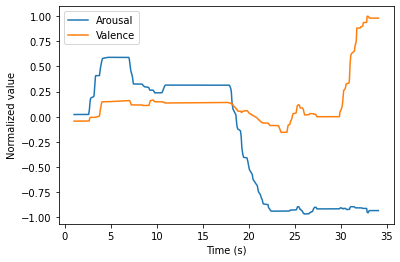

In [19]:
# # Read test data.
# filename = "PID_9__2021-9-7_20h5-11.json"
# trial_no = 8

# # Get filepath.
# filepath = os.path.join(DATA_PATH, filename)

# # Load and clean data.
# df = pd.read_json(filepath)
# df, pid = clean_data(df)

# Extract trial and resample cursor data.
# tmp = df.iloc[trial_no - 1]['time_series']
time, valence, arousal = resample_cursor_data(9,12)

print(time)
my_plot(time, valence, arousal)
time    = None
valence = None 
arousal = None



2
3
4
5
6
7
8
9
